Un regroupement des caractéristiques obtenues est effectué sur une collection d'images définie par (n1,n2).
La collection d'images utilisée est "aloi_red4_view" (72 images par object)  
On va d'abord utiliser l'algorithme du clustering est le k-means  (implémenté à l'aide de la scikitlearn) avec une distance euclidienne.
Les résultats sont évalués à l'aide de métriques comme l'adjusted rand score.

number of objects=10
Number of images= 720
Number of features= 179


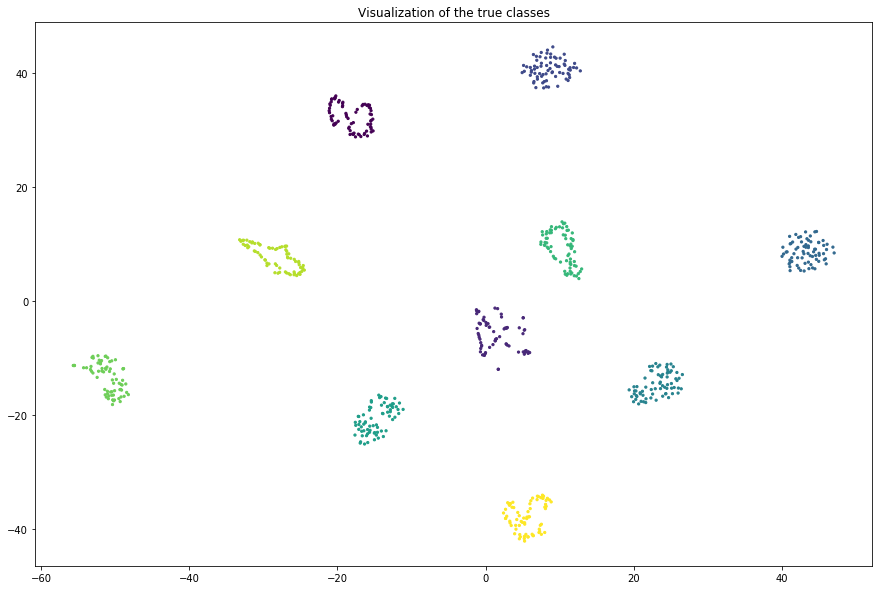



**************Clustering_results*********************
Number of clusters= 10
adjusted_rand_score=0.74
homogeneity_score=0.86
completeness_score=0.92
v_measure_score=0.89
fowlkes_mallows_score=0.78


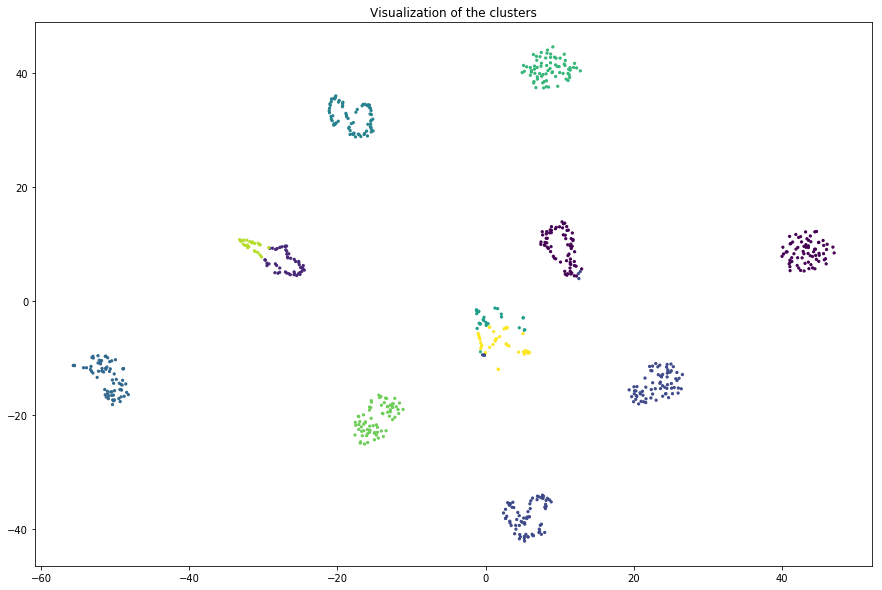

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from Image_reading import *
from Color_descriptors import *
from Shape_descriptors import concatShapeFeatures
from Texture_descriptors import lbp

from KMeansClustering import kmeans_clustering_sklearn

if __name__ == '__main__':
#   Parameters defintion:
    n1=1 # First image (included)
    n2=11 # Last image (excluded)
    n_img=72 # number of images per object
    n_clusters_=n2-n1 # number of objects
    color_space='hsv'
    bins=[4,4,4]
    n_colors=8
    n_fft=64
    hist_size_lbp=100
    
    classes_true=[]
    for i in range(0,n2-n1):
        classes_true=classes_true+[i]*n_img
    classes_true=np.array(classes_true)

#     First, we regroup the images features in a single 2D-Array where each line is the feature vector of an image
    X_all=[]
    for i in range(n_img*(n2-n1)):
        X_all.append([])
    for i in range(n2-n1):
        for j in range(n_img):
            X=read_image_2(i+n1,j)
            
            # *********************************************************
            # ********************Color_features***********************
            # *********************************************************
            # *********************Color_moments***********************
            moments_ftr=moments_calcul(X,color_space)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[moments_ftr]
            # *********************Color_histogram*********************
            hist= color_histogram(X,color_space,bins)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[hist]
            
            """
            # *********************************************************
            # ********************Shape_features***********************
            # *********************************************************
            shape_ftr=concatShapeFeatures(X,n_fft)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[shape_ftr]
            """
            # *********************************************************
            # ********************Texture_features*********************
            # *********************************************************
            lbp_feature=lbp(X,hist_size_lbp)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[lbp_feature]
            
            X_all[n_img*i+j]=np.concatenate(X_all[n_img*i+j])
    
    X_all=np.array(X_all).astype(float)
    print("Number of objects= "+ str(n2-n1))
    print("Number of images= "+ str(X_all.shape[0]))
    print("Number of features= "+ str(X_all.shape[1]))
    
    # ************Visualization_before_clustering******************
    X_norm = StandardScaler().fit_transform(X_all)
    X_embedded = TSNE(n_components=2).fit_transform(X_norm)
    
    plt.figure(figsize=(15,10))
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes_true,s=5)
    plt.title("Visualization of the true classes")
    plt.show()
    print("\n")

    # ********************Clustering************************
    classes=kmeans_clustering_sklearn(X_norm,n_clusters_)
    
    
    print("**************Clustering_results*********************")
    print("Number of clusters= "+str(max(classes)+1))
    print('adjusted_rand_score=%0.2f' % metrics.adjusted_rand_score(classes_true,classes))
    print('homogeneity_score=%0.2f' % metrics.homogeneity_score(classes_true,classes))
    print('completeness_score=%0.2f' % metrics.completeness_score(classes_true,classes))
    print('v_measure_score=%0.2f' % metrics.v_measure_score(classes_true,classes))
    print('fowlkes_mallows_score=%0.2f' % metrics.fowlkes_mallows_score(classes_true,classes))
    
    # ************Visualization_after_clustering******************
    plt.figure(figsize=(15,10))
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes,s=5)
    plt.title("Visualization of the clusters")
    plt.show()
    print("\n")

On remarque qu'en combinant tous les descripteurs, on arrive bien séparer les images par objet (figure 1: Visualization of the true classes). Mais on remarque que l'algorithme k-means n'arrive pas à bien identifier les bons clusters (figure 2: Visualization of the clusters): On obtient un score de l'ordre de 75%.

On va utiliser d'autres défintions de distance. Comme l'outil sklearn n'offre pas la possibilité de modifier la distance, on va se servir d'une autre implémentation du kmeans qui permet de le faire manuellement. D'abord, on teste cette implémentation avec le même type de distance (euclidienne).

Number of objects= 20
Number of images= 1440
Number of features= 179


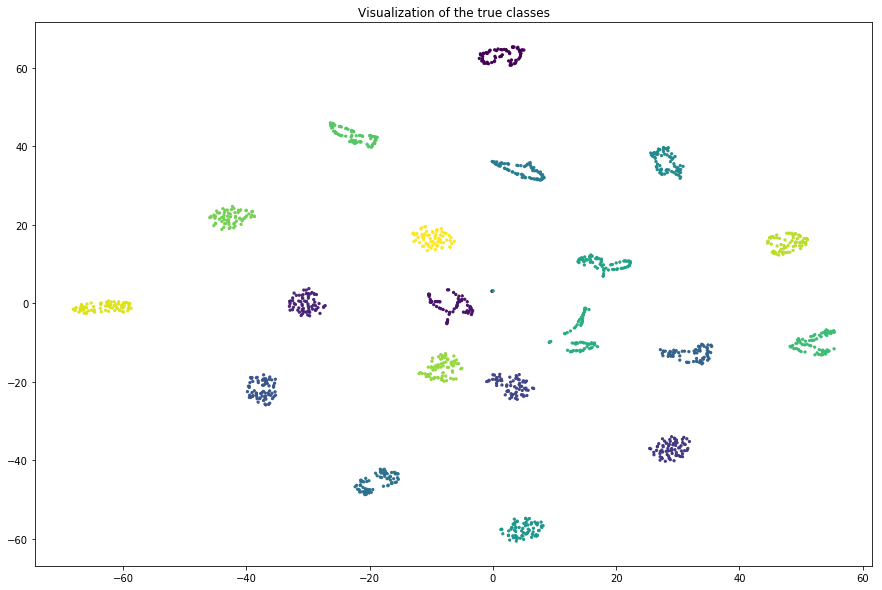



20 4.17703766691823 {0: 87.0, 1: 72.0, 2: 146.0, 3: 144.0, 4: 72.0, 5: 39.0, 6: 34.0, 7: 144.0, 8: 51.0, 9: 72.0, 10: 50.0, 11: 63.0, 12: 3.0, 13: 22.0, 14: 22.0, 15: 13.0, 16: 18.0, 17: 54.0, 18: 301.0, 19: 33.0}
**************Clustering_results*********************
Number of clusters= 20.0
adjusted_rand_score=0.57
homogeneity_score=0.81
completeness_score=0.92
v_measure_score=0.86
fowlkes_mallows_score=0.63


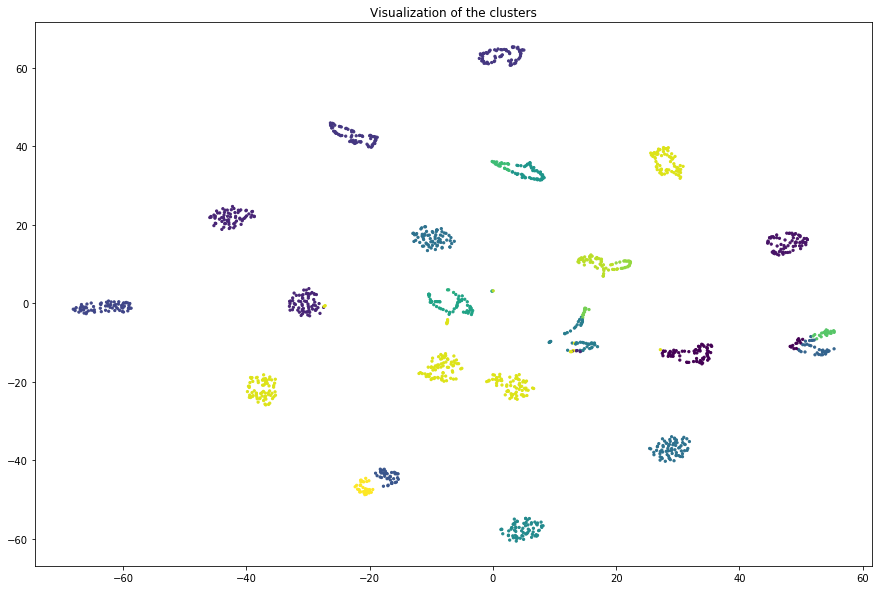

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from Image_reading import *
from Color_descriptors import *
from Shape_descriptors import concatShapeFeatures
from Texture_descriptors import lbp

from KMeansClustering import kmeans_pp

if __name__ == '__main__':
#   Parameters defintion:
    n1=1 # First image (included)
    n2=21 # Last image (excluded)
    n_img=72 # number of images per object
    n_clusters_=n2-n1 # number of objects
    color_space='hsv'
    bins=[4,4,4]
    n_colors=8
    n_fft=64
    hist_size_lbp=100
    
    classes_true=[]
    for i in range(0,n2-n1):
        classes_true=classes_true+[i]*n_img
    classes_true=np.array(classes_true)

#     First, we regroup the images features in a single 2D-Array where each line is the feature vector of an image
    X_all=[]
    for i in range(n_img*(n2-n1)):
        X_all.append([])
    for i in range(n2-n1):
        for j in range(n_img):
            X=read_image_2(i+n1,j)
            
            # *********************************************************
            # ********************Color_features***********************
            # *********************************************************
            # *********************Color_moments***********************
            moments_ftr=moments_calcul(X,color_space)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[moments_ftr]
            # *********************Color_histogram*********************
            hist= color_histogram(X,color_space,bins)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[hist]
            
            """
            # *********************************************************
            # ********************Shape_features***********************
            # *********************************************************
            shape_ftr=concatShapeFeatures(X,n_fft)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[shape_ftr]
            """
            # *********************************************************
            # ********************Texture_features*********************
            # *********************************************************
            lbp_feature=lbp(X,hist_size_lbp)
            X_all[n_img*i+j]=X_all[n_img*i+j]+[lbp_feature]
            
            X_all[n_img*i+j]=np.concatenate(X_all[n_img*i+j])
    
    X_all=np.array(X_all).astype(float)
    print("Number of objects= "+ str(n2-n1))
    print("Number of images= "+ str(X_all.shape[0]))
    print("Number of features= "+ str(X_all.shape[1]))
    
    # ************Visualization_before_clustering******************
    X_norm = StandardScaler().fit_transform(X_all)
    X_embedded = TSNE(n_components=2).fit_transform(X_norm)
    
    plt.figure(figsize=(15,10))
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes_true,s=5)
    plt.title("Visualization of the true classes")
    plt.show()
    print("\n")

    # ********************Clustering************************
    # Distance choice: euclidean, ...
    classes=kmeans_pp(X_norm,n_clusters_,"euclidean")
    
    
    print("**************Clustering_results*********************")
    print("Number of clusters= "+str(max(classes)+1))
    print('adjusted_rand_score=%0.2f' % metrics.adjusted_rand_score(classes_true,classes))
    print('homogeneity_score=%0.2f' % metrics.homogeneity_score(classes_true,classes))
    print('completeness_score=%0.2f' % metrics.completeness_score(classes_true,classes))
    print('v_measure_score=%0.2f' % metrics.v_measure_score(classes_true,classes))
    print('fowlkes_mallows_score=%0.2f' % metrics.fowlkes_mallows_score(classes_true,classes))
    
    # ************Visualization_after_clustering******************
    plt.figure(figsize=(15,10))
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=classes,s=5)
    plt.title("Visualization of the clusters")
    plt.show()
    print("\n")

On remarque que l'implémentation de scikit-learn donne des meilleurs résultats que l'implémentation proposée. Pourtant, on va continuer à travailler avec la 2ème implémentation pour tester plusieurs types de distances.